In [1]:
#montar data en el drive
from google.colab import drive

drive.mount("/drive")

Mounted at /drive


In [2]:
#lugar donde leo tiene la data
%cd "/drive/MyDrive/TAC/TA Final/DataSet"

/drive/MyDrive/TAC/TA Final/DataSet


In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, ReLU, MaxPool2D, AvgPool2D, Input, LeakyReLU, concatenate,Conv2DTranspose, UpSampling2D
import cv2
import os
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam, RMSprop, Adagrad
from keras.layers.normalization import BatchNormalization
import math
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
import nibabel as nib

from tensorflow.keras.models import Model
from keras.layers import add

In [4]:
size = 128

In [5]:
def encoder_module(in_layer, n_filters):
  x = in_layer
  saved_layers = []
  #array ---> [64,128,256,512]
  for filters in [n_filters,n_filters<<1,n_filters<<2,n_filters<<3]:
    x = Conv2D(filters, kernel_size=3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    #x = Conv2D(filters, kernel_size=3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
    #push a la pila de capas guardadas
    saved_layers.insert(0,x)
    x = MaxPool2D(2, padding="same")(x)
  
  x = Conv2D(n_filters<<4, kernel_size=3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
  #x = Conv2D(n_filters<<4, kernel_size=3, activation='relu', padding='same',kernel_initializer='he_normal')(x)
  #saved layers es [(512,), (256,), (128,), (64,)]
  return x, saved_layers

In [6]:
#Al entrenar probaremos: 
#1. Hacer un bottleneck para sumar antes de las deConvolusiones
#2. El add al medio de las dos convolusiones

def decoder_module(last_layer,n_filters,saved_layers):
  x = last_layer
  #array ---> [512,256,128,64]
  for (filters,add_layer) in zip([n_filters>>1,n_filters>>2,n_filters>>3,n_filters>>4], saved_layers):
    #UpSampling
    x = UpSampling2D(2)(x)
    #DeConvolutions
    #x = Conv2DTranspose(filters, kernel_size=3, padding="same")(x)
    x = Conv2DTranspose(filters, kernel_size=3, padding="same")(x)
    #Suma de Capas
    x = add([x,add_layer])

  return x

In [7]:
def create_unet():
  #El numero de filtros es un hiperparametro
  min_filters = 64
  max_filters = 1024

  in_layer = Input(shape=(size,size,1))
  #Encoder
  last_layer, saved_layers = encoder_module(in_layer,min_filters)
  #Decoder
  decoded_layer = decoder_module(last_layer,max_filters,saved_layers)
  #Outpus
  outputs = Conv2D(3, 3, activation="softmax", padding="same")(decoded_layer)
  model = Model(inputs=in_layer, outputs=outputs)
  return model

In [8]:
#Modelo
model = create_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [92]:
#lectura de data
images_paths = [("./Resized Images/" + x) for x in os.listdir("Resized Images")]
images_paths.sort()
images_paths = images_paths[0:300]

masks_paths = [("./Resized Masks/" + x) for x in os.listdir("Resized Masks")]
masks_paths.sort()
masks_paths = masks_paths[0:300]
print("Resized Images scan with length of: {}".format(len(images_paths)))
print("Resized Masks scan with length of: {}".format(len(masks_paths)))

Resized Images scan with length of: 300
Resized Masks scan with length of: 300


In [99]:
def normalize_data(data):
  # Scale the HU values to be between 0 and 1
  mean = 0.5
  std = 0.5
  data = (data - mean) / std
  #Canal de grayscale
  #data = data.reshape((-1,size, size, 1))
  
  return data

def read_process_data(path):
  data = cv2.imread(path)
  #Conversion a escala de grises
  data = np.dot(data[...,:3], [0.299, 0.587, 0.144])
  data = cv2.normalize(data, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
  return data

In [100]:
#lectura de las imagenes
%%time
images = np.array([read_process_data(path) for path in images_paths])
images_test = images

CPU times: user 261 ms, sys: 62.2 ms, total: 323 ms
Wall time: 674 ms


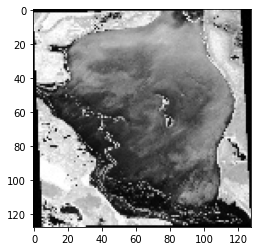

In [120]:
plt.imshow(images_test[5],cmap='gray')

In [ ]:
print(images_test[5])

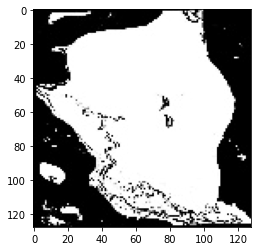

In [137]:
plt.imshow(masks_test[5],cmap='gray')

In [139]:
images_test = images_test.reshape((-1, size, size, 1))
masks_test = masks_test.reshape((-1, size, size, 1))

In [136]:
images_test = images
masks_test = masks

In [140]:
#Comprobamos las dimensiones del dataset
print("images shape: {} masks shape: {}".format(images_test.shape,masks_test.shape))

images shape: (300, 128, 128, 1) masks shape: (300, 128, 128, 1)


In [141]:
x_train, x_val, y_train, y_val = train_test_split(images_test, masks_test, test_size=0.20, random_state=42)

In [152]:
bs = 64
dataset_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset_train = dataset_train.shuffle(buffer_size=100).batch(bs).prefetch(50)
dataset_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
dataset_val = dataset_test.batch(bs).prefetch(50)

In [153]:
dataset_val

<PrefetchDataset shapes: ((None, None, 128, 128, 1), (None, None, 128, 128, 1)), types: (tf.float64, tf.float64)>

In [154]:
#run with checkpoint
checkpoint_path = "my_model/model"
monitor = "val_accuracy"
mode = "max"
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor=monitor, verbose=1, save_best_only=True, save_weights_only=True, mode=mode)

In [155]:
#Probar con diferentes loss functions
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [156]:
log = model.fit(dataset_train, batch_size=bs,epochs=10, validation_data=dataset_val)

Epoch 1/10
4/4 [==============================] - ETA: 0s - loss: nan - accuracy: 0.0000e+00WARNING:tensorflow:Model was constructed with shape (None, 128, 128, 1) for input KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'"), but it was called on an input with incompatible shape (None, None, 128, 128).


ValueError: ignored